# plot

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import greatpy as great 
import bindome as bd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import pandas as pd 
import numpy as np 

import time

In [9]:
test = "../data/tests/test_data/input/01_random.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"

## Count plot

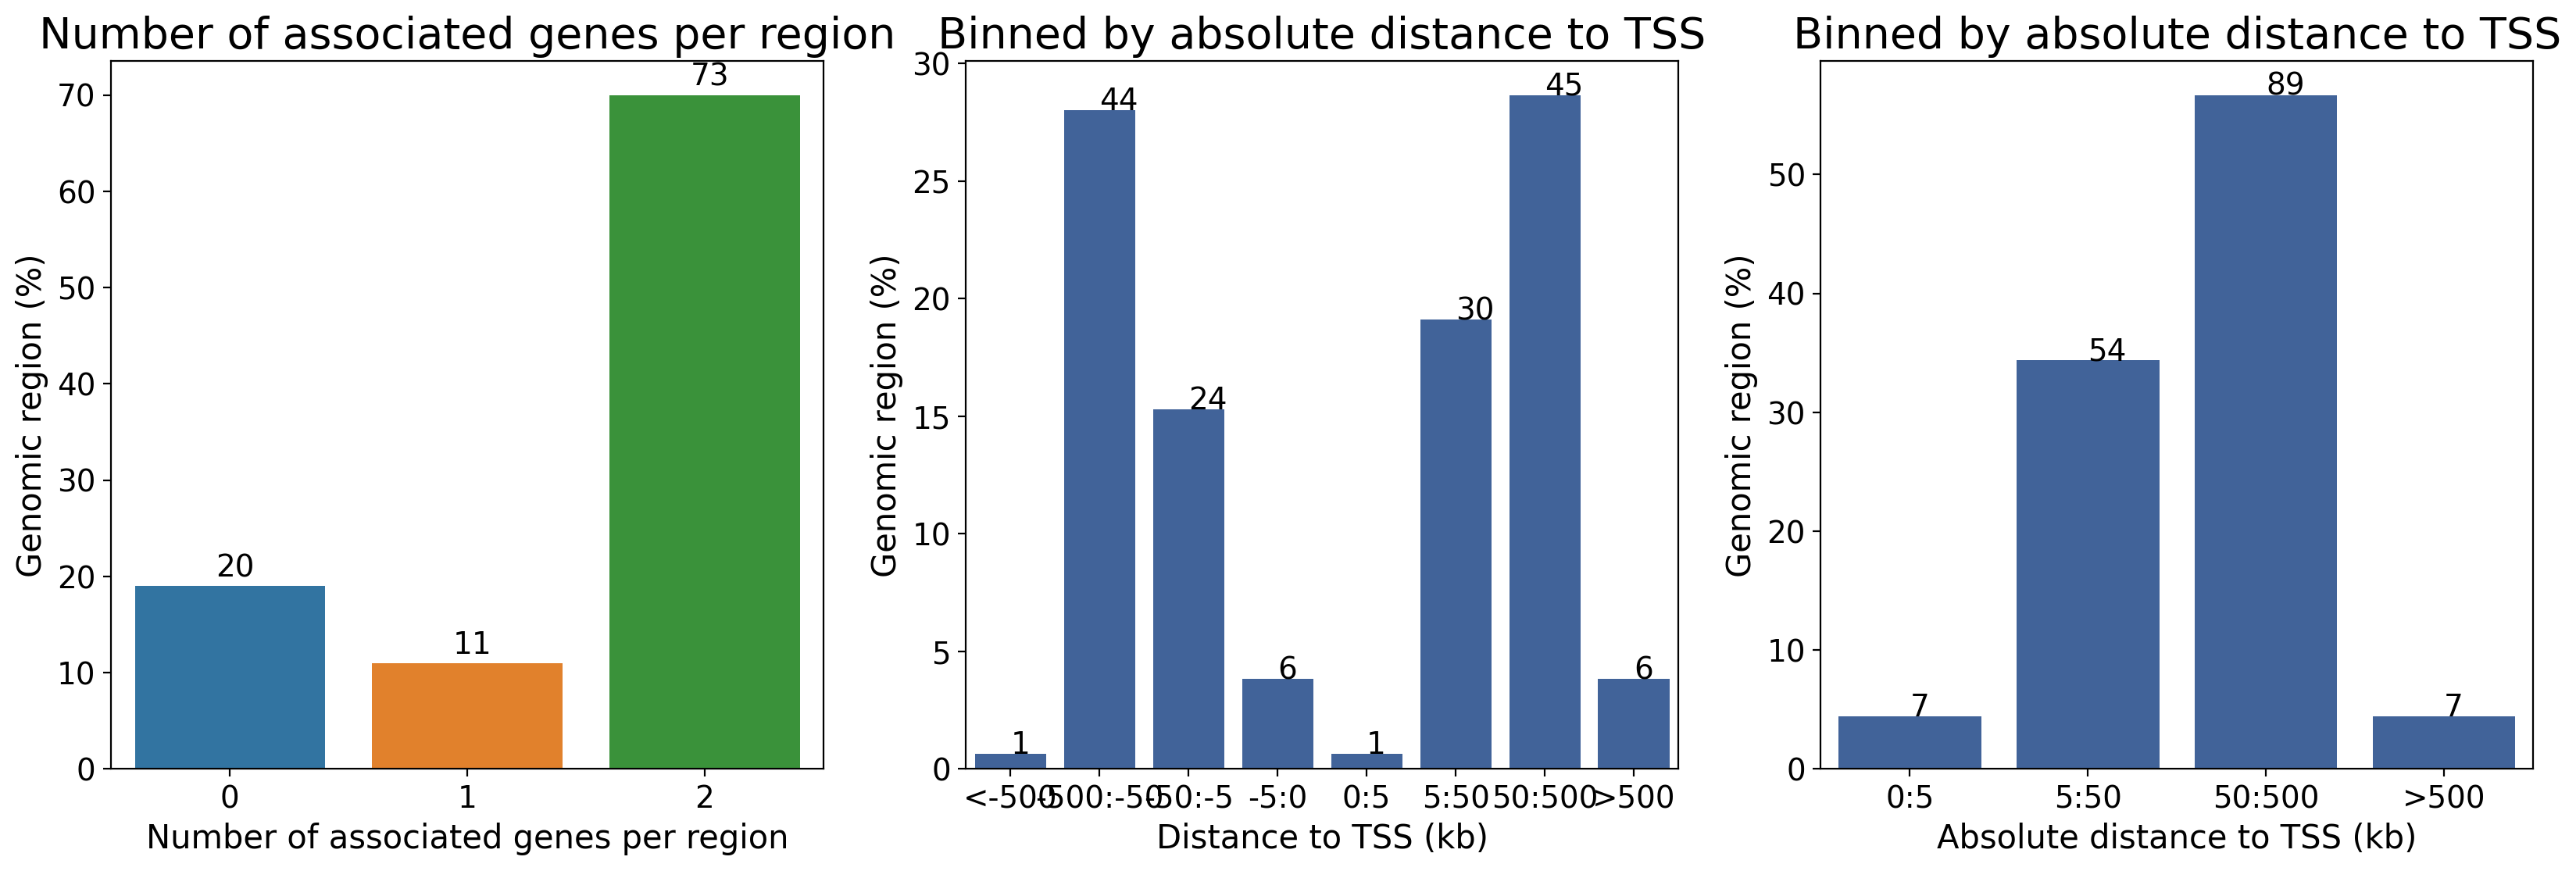

In [10]:
fig,ax = plt.subplots(1,3,figsize = (20,6),dpi=200)
great.pl.graph_nb_asso_per_peaks(test,regdom,ax[0])
great.pl.graph_dist_tss(test,regdom,ax[1])
great.pl.graph_absolute_dist_tss(test,regdom,ax[2])
plt.show()

## Dotplot

### Dotplot of the enrichment 

In [11]:
enrichment = great.tl.GREAT.enrichment(
    test,
    regdom,
    "../data/human/hg38/chr_size.bed", 
    "../data/human/ontologies.csv"
)

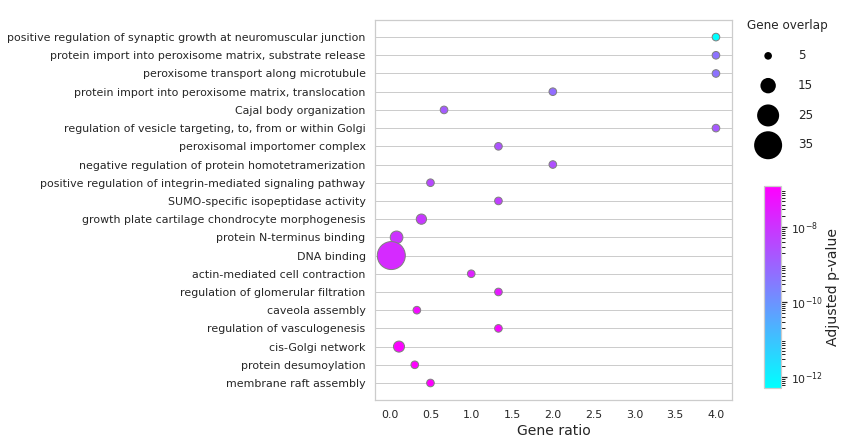

In [12]:
plot = enrichment.rename(columns = {"binom_p_value" : "p_value", "go_term":"name"})
plt.figure(figsize = (8,7))
great.pl.plot_enrich(plot)

### Dotoplot of multi-enrichment sample

In [14]:
test = [
    "SRF:Ishikawa,A-673-clone-Asp114,K-562,MCF-7,Hep-G2",
    "MAX:K-562,WA01,HeLa-S3", "BACH1:A-549,GM12878",
    "CDK9:A-375,MM1-S,MV4-11,P493-6,BT-474,HEK293T",
    "GATA1:erythroblast,HUDEP-2,K-562", "IKZF1:K-562,GM12878,HSPC", 
    "SP1:liver,A-375,Hep-G2,HEK293,GM12878,A-549,K-562,HEK293T,WA01",
    "TCF7:Hep-G2,GM12878,K-562", "ZBTB40:MCF-7,Hep-G2,GM12878",
    "AFF1:MV4-11,K-562"
    ]

results = great.tl.GREAT.enrichment_multiple(
    tests = test, 
    regdom_file = "../data/human/hg38/regulatory_domain.bed",
    chr_size_file = "../data/human/hg38/chr_size.bed",
    annotation_file = "../data/human/ontologies.csv",
    binom = True,
    hypergeom = True,
)

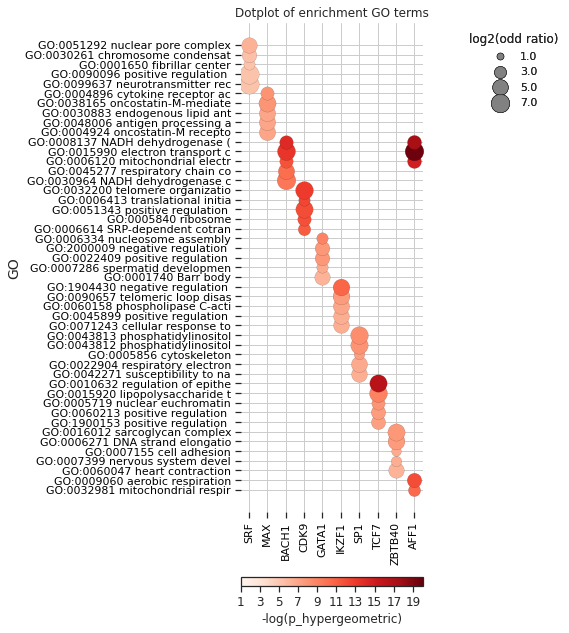

In [28]:
fig = plt.figure(figsize = (15, 12))
p_val,odd_ratio,df = great.pl.dotplot_multi_sample(results,fig = fig,show_term_name = True,term_name_nchars = 20)

In [16]:
df.head(10)

,id,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall,index
0,GO:0051292,nuclear pore complex assembly,8.97009e-04,3.18950e+03,6.28405e+00,4.94165e+00,2.00000e+00,1.53846e-01,0
1,GO:0030261,chromosome condensation,1.27056e-03,2.67271e+03,5.51863e+00,4.39416e+00,2.00000e+00,1.05263e-01,0
2,GO:0001650,fibrillar center,5.87653e-03,3.85300e+02,5.30190e+00,2.54406e+00,4.00000e+00,2.91971e-02,0
3,GO:0090096,positive regulation of metanephric cap mesench...,2.80032e-02,2.42984e+03,5.29709e+00,7.64209e+00,1.00000e+00,1.00000e+00,0
4,GO:0099637,neurotransmitter receptor transport,6.30720e-03,1.09058e+04,5.29709e+00,7.64209e+00,1.00000e+00,1.00000e+00,0
0,GO:0004896,cytokine receptor activity,3.31342e-03,8.66841e+02,7.98072e+00,3.58059e+00,3.00000e+00,6.97674e-02,1
1,GO:0038165,oncostatin-M-mediated signaling pathway,5.28500e-02,1.56594e+03,7.93887e+00,6.00685e+00,1.00000e+00,2.50000e-01,1
2,GO:0030883,endogenous lipid antigen binding,1.45583e-02,5.79649e+03,7.03282e+00,5.42189e+00,1.00000e+00,1.66667e-01,1
3,GO:0048006,"antigen processing and presentation, endogenou...",1.45583e-02,5.79649e+03,7.03282e+00,5.42189e+00,1.00000e+00,1.66667e-01,1
4,GO:0004924,oncostatin-M receptor activity,5.19264e-02,1.59456e+03,7.03282e+00,5.42189e+00,1.00000e+00,1.66667e-01,1


In [17]:
p_val.head()

index,SRF,MAX,BACH1,CDK9,GATA1,IKZF1,SP1,TCF7,ZBTB40,AFF1
test,,,,,,,,,,
GO:0051292 nuclear pore complex,6.28405e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0030261 chromosome condensat,5.51863e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0001650 fibrillar center,5.30190e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0090096 positive regulation,5.29709e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0099637 neurotransmitter rec,5.29709e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00


In [18]:
odd_ratio.head()

index,SRF,MAX,BACH1,CDK9,GATA1,IKZF1,SP1,TCF7,ZBTB40,AFF1
test,,,,,,,,,,
GO:0051292 nuclear pore complex,4.94165e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
GO:0030261 chromosome condensat,4.39416e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
GO:0001650 fibrillar center,2.54406e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
GO:0090096 positive regulation,7.64209e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
GO:0099637 neurotransmitter rec,7.64209e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
